In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib
from sklearn.model_selection import train_test_split
import itertools
import re
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_unemployment=pd.read_csv('Japan Dataset\DP_LIVE_18042023124659745.csv')
df_unemployment.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HUR,TOT,PC_LF,A,1967,1.875,NaN
1,AUS,HUR,TOT,PC_LF,A,1968,1.850,NaN
2,AUS,HUR,TOT,PC_LF,A,1969,1.800,NaN
3,AUS,HUR,TOT,PC_LF,A,1970,1.625,NaN
4,AUS,HUR,TOT,PC_LF,A,1971,1.925,NaN


In [3]:
df_unemployment_japan=df_unemployment[(df_unemployment['LOCATION']=='JPN')&(df_unemployment['SUBJECT']=='TOT')].copy()
df_unemployment_japan_men=df_unemployment[(df_unemployment['LOCATION']=='JPN')&(df_unemployment['SUBJECT']=='MEN')].copy()
df_unemployment_japan_women=df_unemployment[(df_unemployment['LOCATION']=='JPN')&
                                            (df_unemployment['SUBJECT']=='WOMEN')].copy()

In [4]:
df_unemployment_japan_monthly=df_unemployment_japan[df_unemployment_japan['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]
df_unemployment_japan_men_monthly=df_unemployment_japan_men[df_unemployment_japan_men['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]
df_unemployment_japan_women_monthly=df_unemployment_japan_women[df_unemployment_japan_women['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]

In [5]:
[val for val in df_unemployment_japan_men_monthly['TIME'].to_list() if val not in df_unemployment_japan_monthly['TIME'].to_list()]

['1953-01',
 '1953-02',
 '1953-03',
 '1953-04',
 '1953-05',
 '1953-06',
 '1953-07',
 '1953-08',
 '1953-09',
 '1953-10',
 '1953-11',
 '1953-12',
 '1954-01',
 '1954-02',
 '1954-03',
 '1954-04',
 '1954-05',
 '1954-06',
 '1954-07',
 '1954-08',
 '1954-09',
 '1954-10',
 '1954-11',
 '1954-12']

In [6]:
df_unemployment_japan_men_monthly['TIME']=pd.to_datetime(df_unemployment_japan_men_monthly['TIME'],format='%Y-%m')
df_unemployment_japan_men_monthly=df_unemployment_japan_men_monthly.set_index('TIME')

In [7]:
df_unemployment_japan_men_monthly.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,Value,Flag Codes
TIME,,,,,,,
1953-01-01,JPN,HUR,MEN,PC_LF,M,1.9,NaN
1953-02-01,JPN,HUR,MEN,PC_LF,M,1.9,NaN
1953-03-01,JPN,HUR,MEN,PC_LF,M,1.9,NaN
1953-04-01,JPN,HUR,MEN,PC_LF,M,2.0,NaN
1953-05-01,JPN,HUR,MEN,PC_LF,M,2.1,NaN


# 1. Baseline Model : Univariate Time Series ARIMA

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

## 1.1. EDA

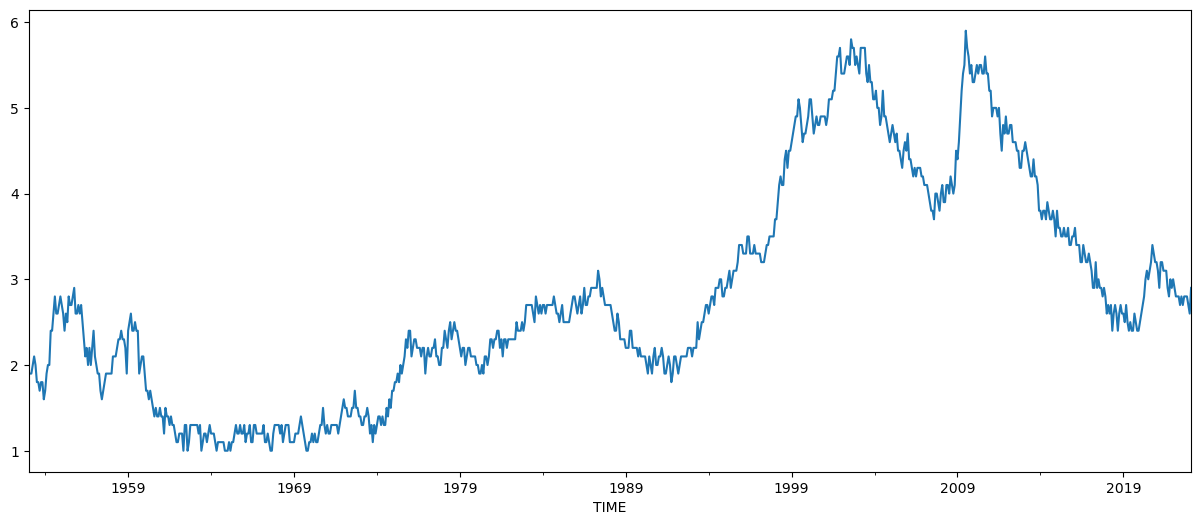

In [8]:
df_unemployment_japan_men_monthly['Value'].plot(figsize=(15, 6))
plt.show()

### 1.1.1. Decomposing Time Series to Trend, Seasonality and Residuals

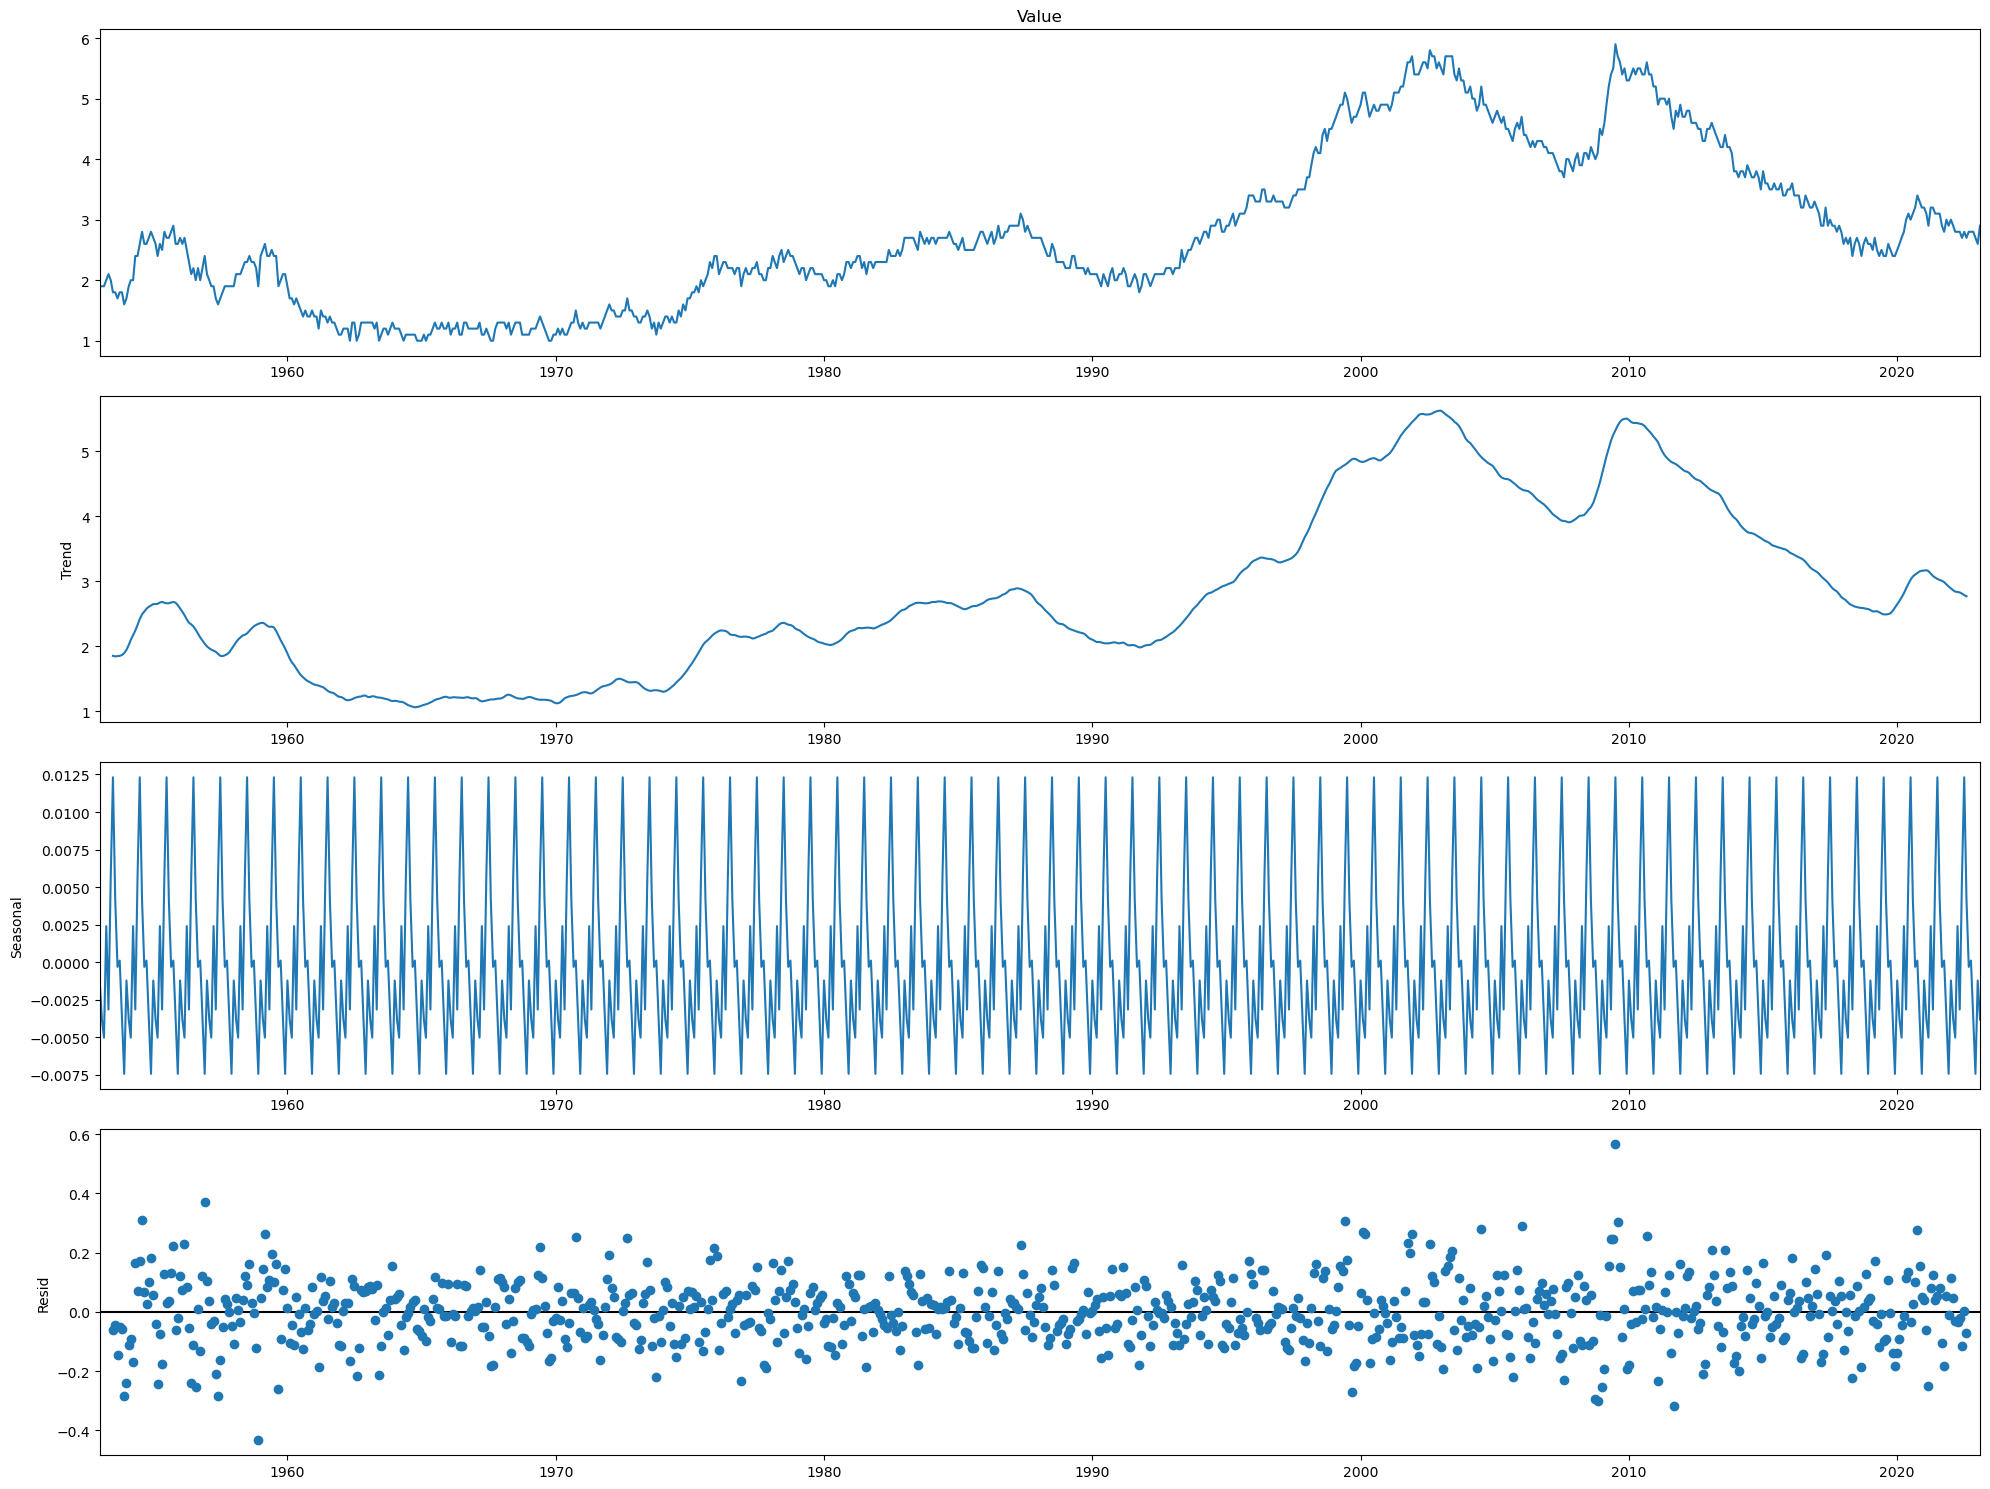

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15
decomposition = sm.tsa.seasonal_decompose(df_unemployment_japan_men_monthly['Value'], model='additive')
fig = decomposition.plot()
plt.show()

### 1.1.2. Checking Stationarity and De-Trending

In [10]:
adfuller_result = adfuller(df_unemployment_japan_men_monthly['Value'].values, autolag='AIC')
print('ADF statistics: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])
if adfuller_result[1] >= 0.05:
    print('Non-stationary time series, convert to stationary time series')
else:
    print('Stationary time series, ARIMA can be implemented')

ADF statistics:  -1.544341289453866
p-value:  0.5114735421273088
Non-stationary time series, convert to stationary time series


## 1.2. Modelling 

In [11]:
X_train=df_unemployment_japan_men_monthly.iloc[0:800,0:5]
Y_train=df_unemployment_japan_men_monthly.iloc[0:800,5]

X_test=df_unemployment_japan_men_monthly.iloc[800:,0:5]
Y_test=df_unemployment_japan_men_monthly.iloc[800:,5]

### 1.2.1. Determining optimum p,d,q values

In [12]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [13]:
warnings.filterwarnings("ignore")
aic_value=99999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(Y_train,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
        if results.aic<aic_value:
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            aic_value=results.aic

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4066.8858188153636
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3035.679221802793
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:768.9229997039411
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:683.9335664404734
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:680.6939598898128
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:201.03169181097704
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:176.3735908517586
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:176.16456859079435
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-1023.1757070067713
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-1082.123735161233
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-1108.1362375480821
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-1113.5103245775954
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-1114.9676899951855


### 1.2.2. Fitting Model

In [14]:
mod = sm.tsa.statespace.SARIMAX(Y_train,
                                order=(1, 1, 0),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1196      0.034     -3.478      0.001      -0.187      -0.052
ar.S.L12       0.3193      0.067      4.745      0.000       0.187       0.451
ma.S.L12      -0.6799      0.054    -12.660      0.000      -0.785      -0.575
sigma2         0.0139      0.001     20.483      0.000       0.013       0.015


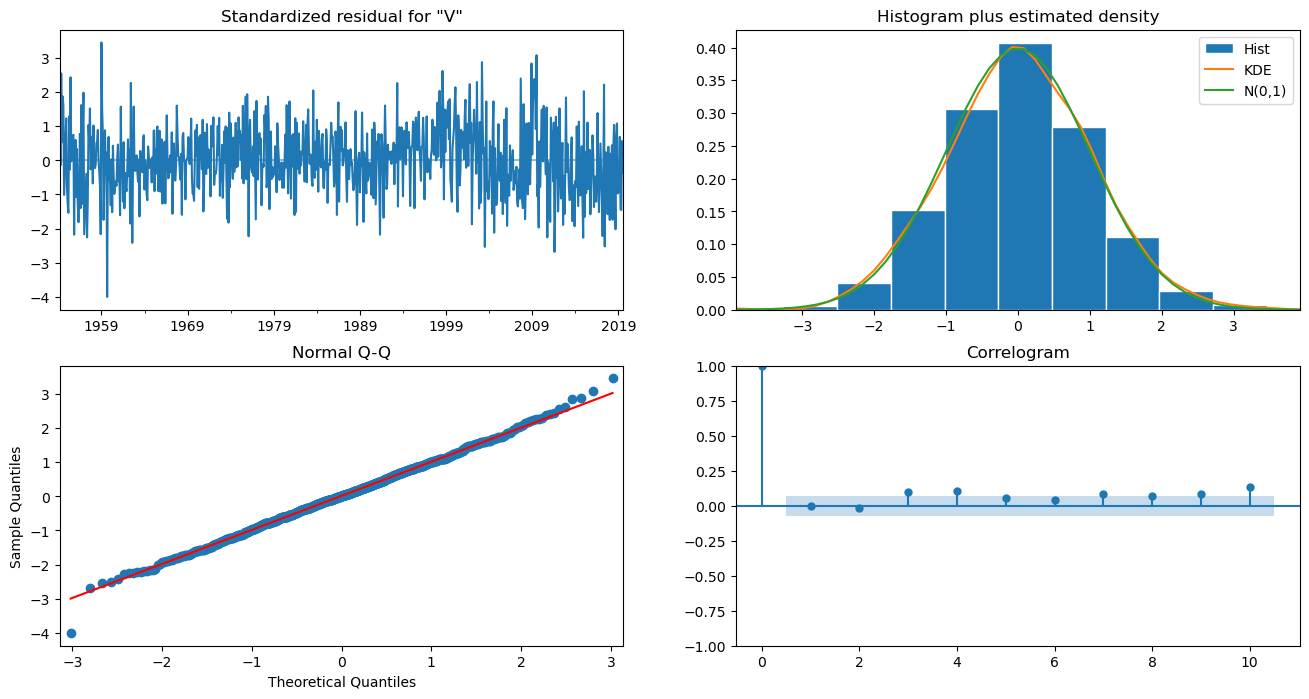

In [15]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### 1.2.3. Model Results

In [16]:
predictions={}
for date in Y_test.index:
    pred=results.get_prediction(pd.to_datetime(date))
    predictions[date]=pred.predicted_mean[0]

In [17]:
y_forecasted = np.array(list(predictions.values()))
y_truth = Y_test.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


# 2. Multivariate Time Series Forecasting with LSTMs

## 2.1. DATA prep and EDA

In [18]:
df_production_labour=pd.read_excel(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\imf\prices_production_and_labour\Prices_Production_and_Labor_Japan.xlsx',sheet_name='Monthly_Data')
df_production_labour['Indicator'].unique()

array(['Prices', 'Financial Market Prices, Equities, Index',
       'Prices, Producer Price Index, All Commodities, Index',
       'Prices, Consumer Price Index, All items, Index', 'Production',
       'Economic Activity, Industrial Production, Manufacturing, Index',
       'Economic Activity, Industrial Production, Index',
       'Industrial Production, Seasonally adjusted, Index', 'Labor',
       'Labor Markets, Wage Rates, Index',
       'Labor Force, Persons, Number of',
       'Employment, Persons, Number of',
       'Unemployment, Persons, Number of',
       'Labor Markets, Unemployment Rate, Percent'], dtype=object)

In [19]:
time_col=[col for col in df_production_labour.columns if re.search(r'\d{4}',str(col),re.I)!=None]

df_production_labour_restructured=pd.melt(df_production_labour,id_vars='Indicator',value_vars=time_col,var_name='timeframe')
df_production_labour_restructured=pd.pivot(df_production_labour_restructured,index='timeframe',columns='Indicator',values='value').reset_index()

df_production_labour_restructured['timeframe_year']=df_production_labour_restructured['timeframe'].str.split('M',expand=True)[0]
df_production_labour_restructured['timeframe_month']=df_production_labour_restructured['timeframe'].str.split('M',expand=True)[1]

df_production_labour_restructured['TIME']=df_production_labour_restructured['timeframe_year']+'-'+df_production_labour_restructured['timeframe_month']

df_production_labour_restructured.drop(columns=['timeframe','timeframe_month','timeframe_year','Prices'],inplace=True)

In [20]:
df_MRD=pd.merge(df_unemployment_japan_monthly,df_production_labour_restructured,on='TIME',how='inner')
df_MRD['TIME']=pd.to_datetime(df_MRD['TIME'],format='%Y-%m')
df_MRD=df_MRD.set_index('TIME')

feature_col=['Economic Activity, Industrial Production, Index','Economic Activity, Industrial Production, Manufacturing, Index',
             'Financial Market Prices, Equities, Index','Industrial Production, Seasonally adjusted, Index',
             'Labor Markets, Wage Rates, Index','Prices, Consumer Price Index, All items, Index',
             'Prices, Producer Price Index, All Commodities, Index']

target_col=['Value']

df_MRD=df_MRD[feature_col+target_col]
for col in df_MRD.columns:
    df_MRD[col]=pd.to_numeric(df_MRD[col],errors='coerce')
    
df_MRD.head()

,"Economic Activity, Industrial Production, Index","Economic Activity, Industrial Production, Manufacturing, Index","Financial Market Prices, Equities, Index","Industrial Production, Seasonally adjusted, Index","Labor Markets, Wage Rates, Index","Prices, Consumer Price Index, All items, Index","Prices, Producer Price Index, All Commodities, Index",Value
TIME,,,,,,,,
1990-01-01,90.630605,92.593293,311.508388,98.176707,86.385602,92.937029,107.607981,2.2
1990-02-01,96.407061,99.373580,302.643796,98.670057,87.185469,93.040637,107.607981,2.2
1990-03-01,109.354291,113.146037,255.843582,100.446118,87.585402,93.351464,107.705629,2.0
1990-04-01,100.988389,104.564737,244.278173,100.643458,89.085152,94.180333,107.705629,2.1
1990-05-01,97.701784,101.068651,267.136876,101.334148,88.885186,94.594768,107.607981,2.1


In [21]:
scaler=MinMaxScaler()
df_MRD_scaled=scaler.fit_transform(df_MRD)
df_MRD_scaled=pd.DataFrame(df_MRD_scaled,columns=df_MRD.columns)

df_MRD_scaled.index=df_MRD.index
df_MRD_scaled.head()

,"Economic Activity, Industrial Production, Index","Economic Activity, Industrial Production, Manufacturing, Index","Financial Market Prices, Equities, Index","Industrial Production, Seasonally adjusted, Index","Labor Markets, Wage Rates, Index","Prices, Consumer Price Index, All items, Index","Prices, Producer Price Index, All Commodities, Index",Value
TIME,,,,,,,,
1990-01-01,0.380511,0.409522,1.000000,0.549048,0.000000,0.000000,0.858974,0.057143
1990-02-01,0.487775,0.531892,0.961302,0.561362,0.042781,0.005925,0.858974,0.057143
1990-03-01,0.728193,0.780457,0.756997,0.605689,0.064171,0.023700,0.865385,0.000000
1990-04-01,0.572846,0.625582,0.706508,0.610614,0.144385,0.071100,0.865385,0.028571
1990-05-01,0.511817,0.562485,0.806297,0.627852,0.133690,0.094801,0.858974,0.028571


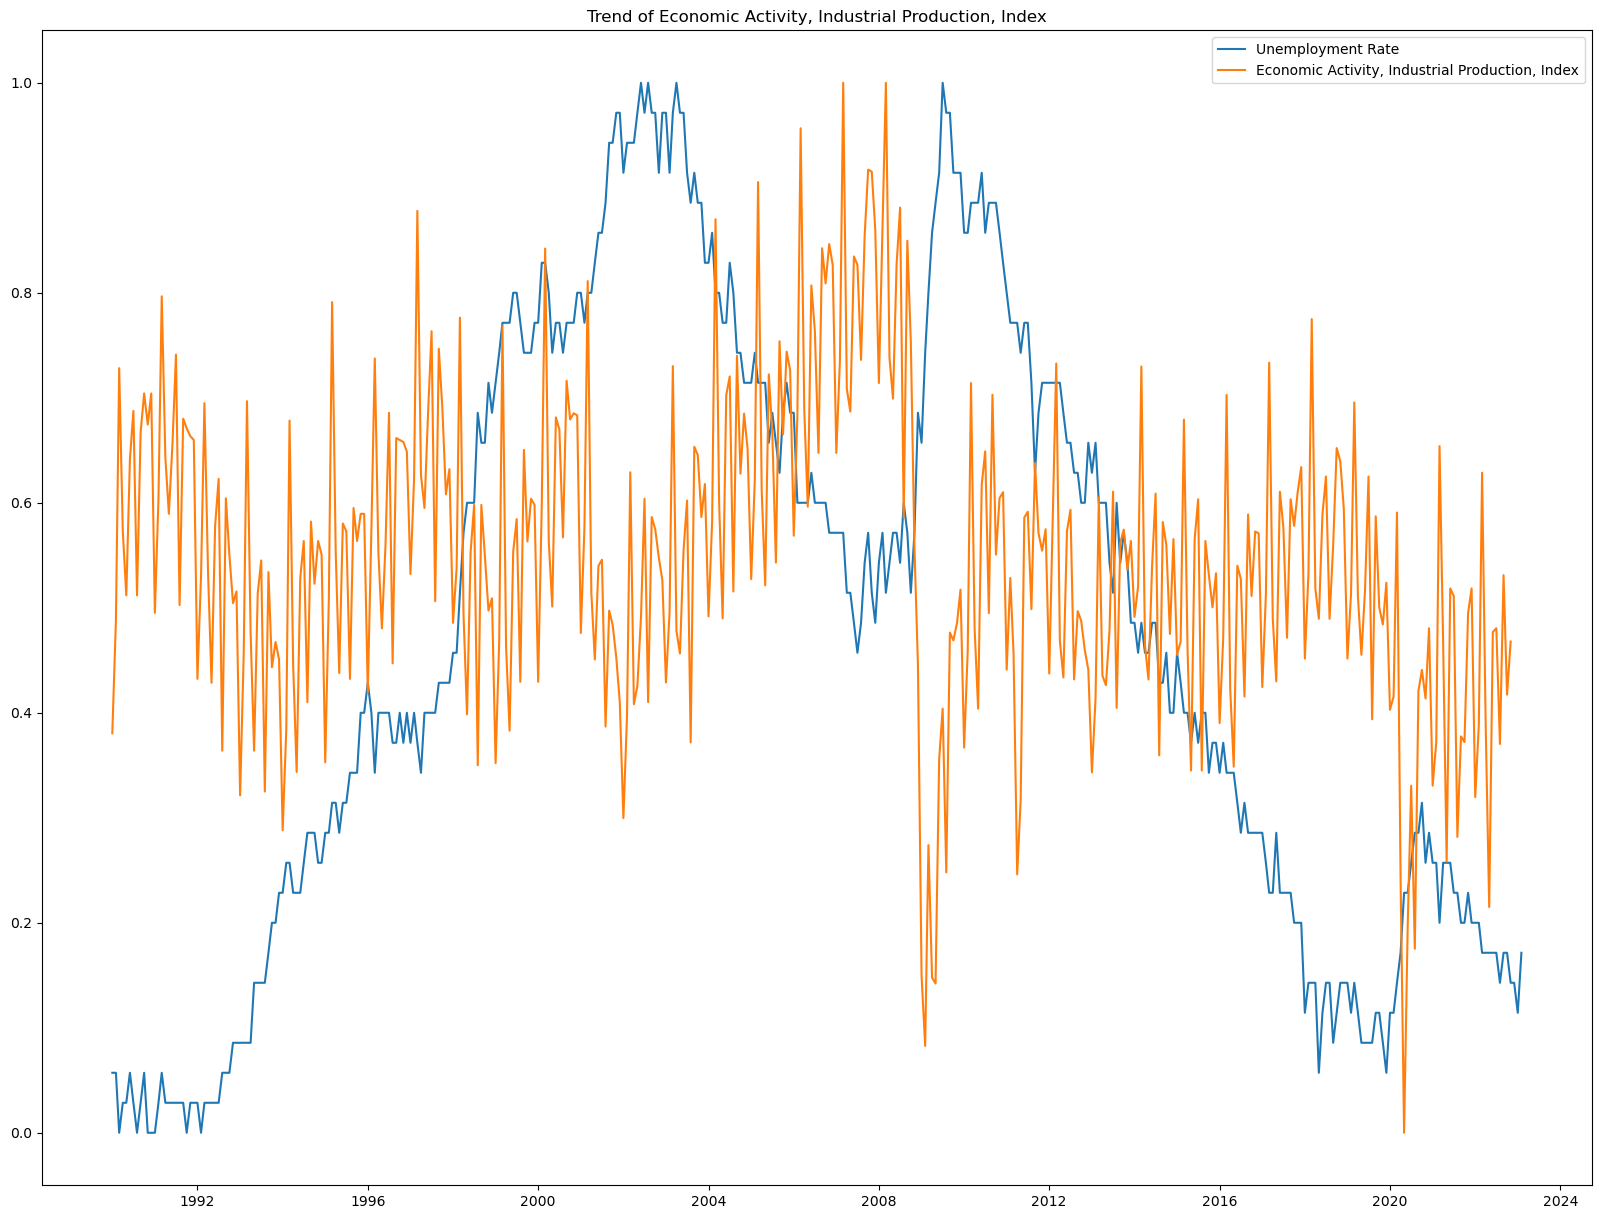

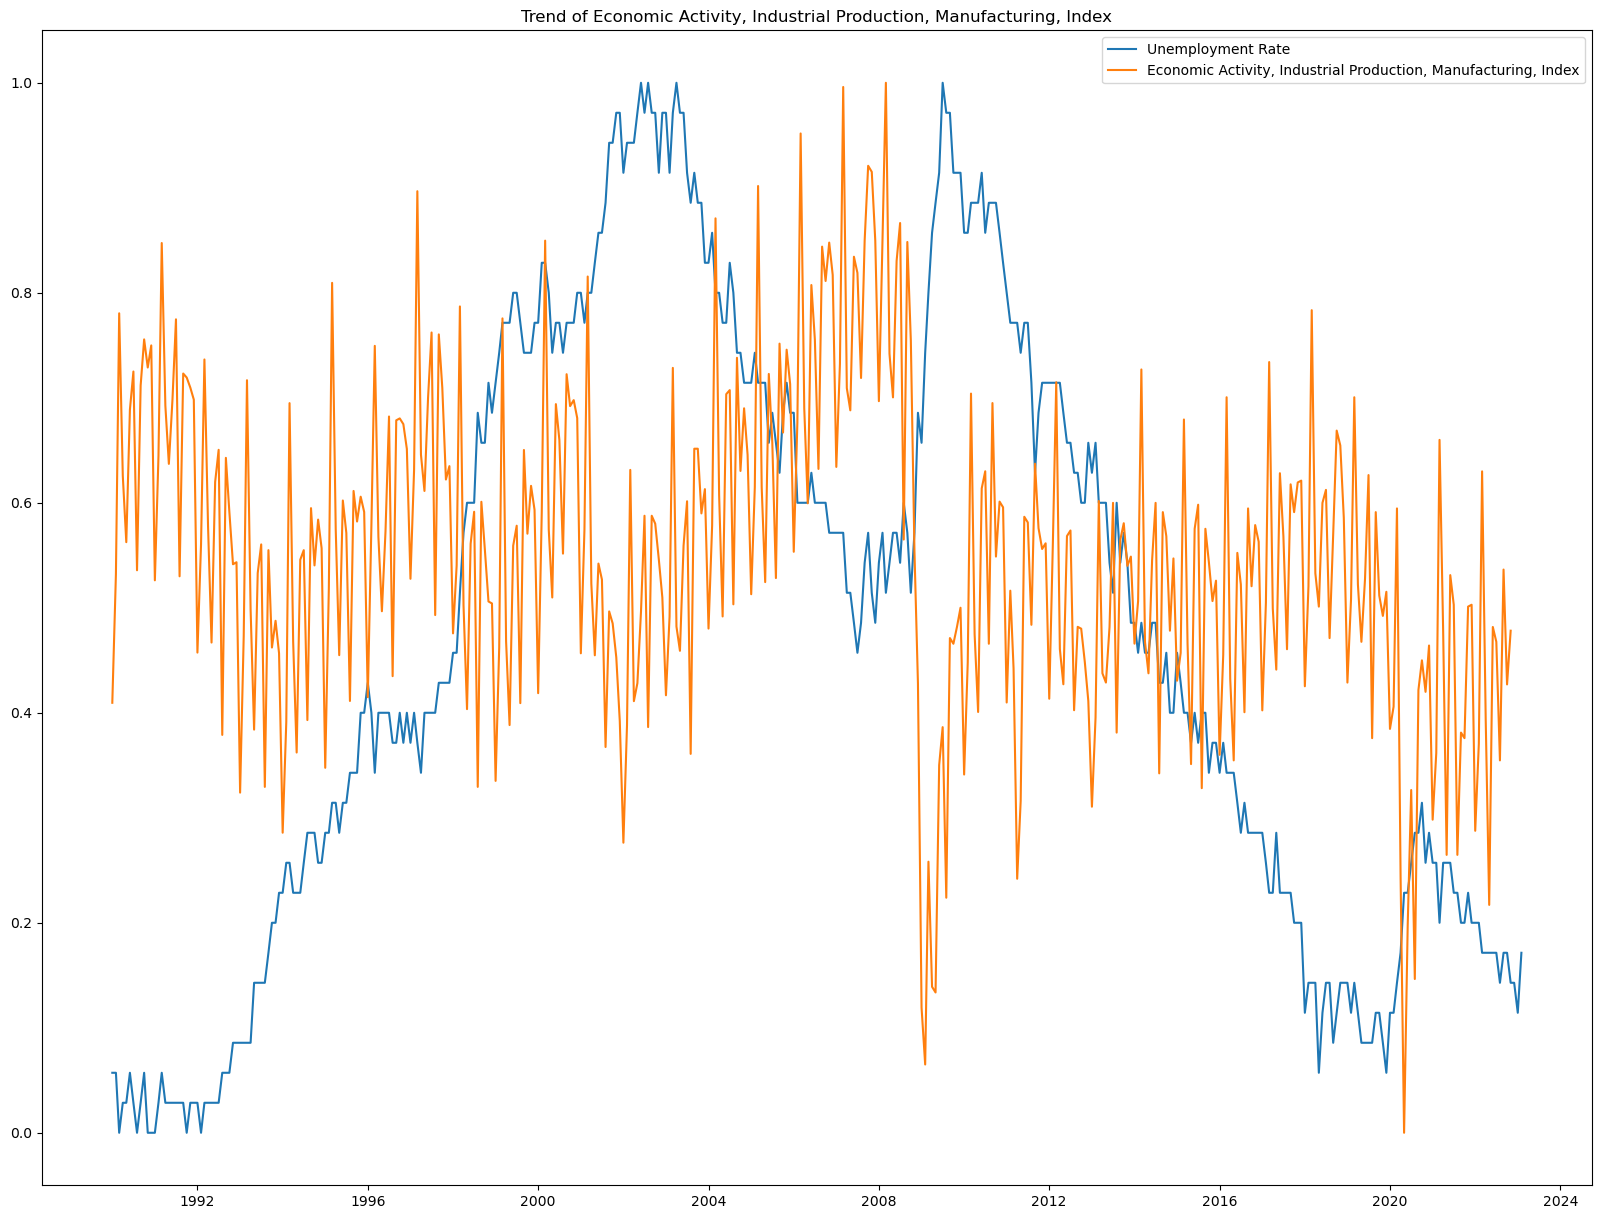

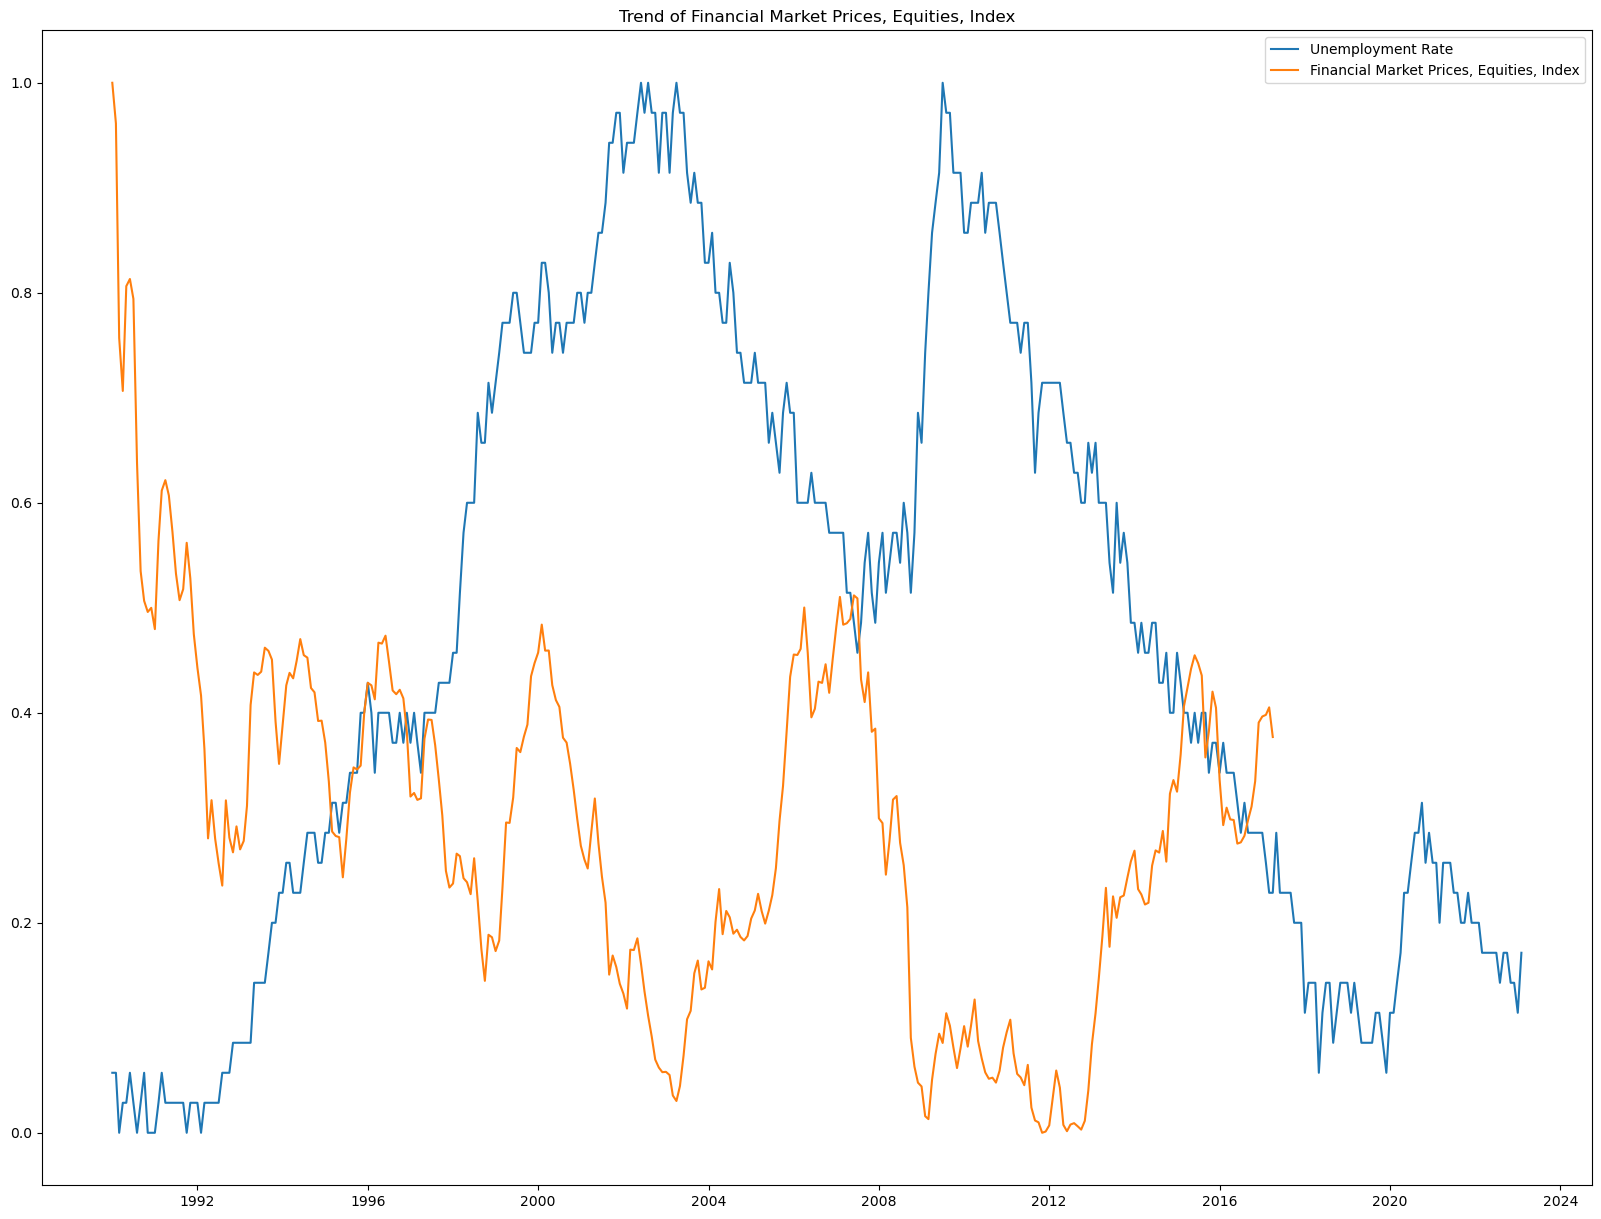

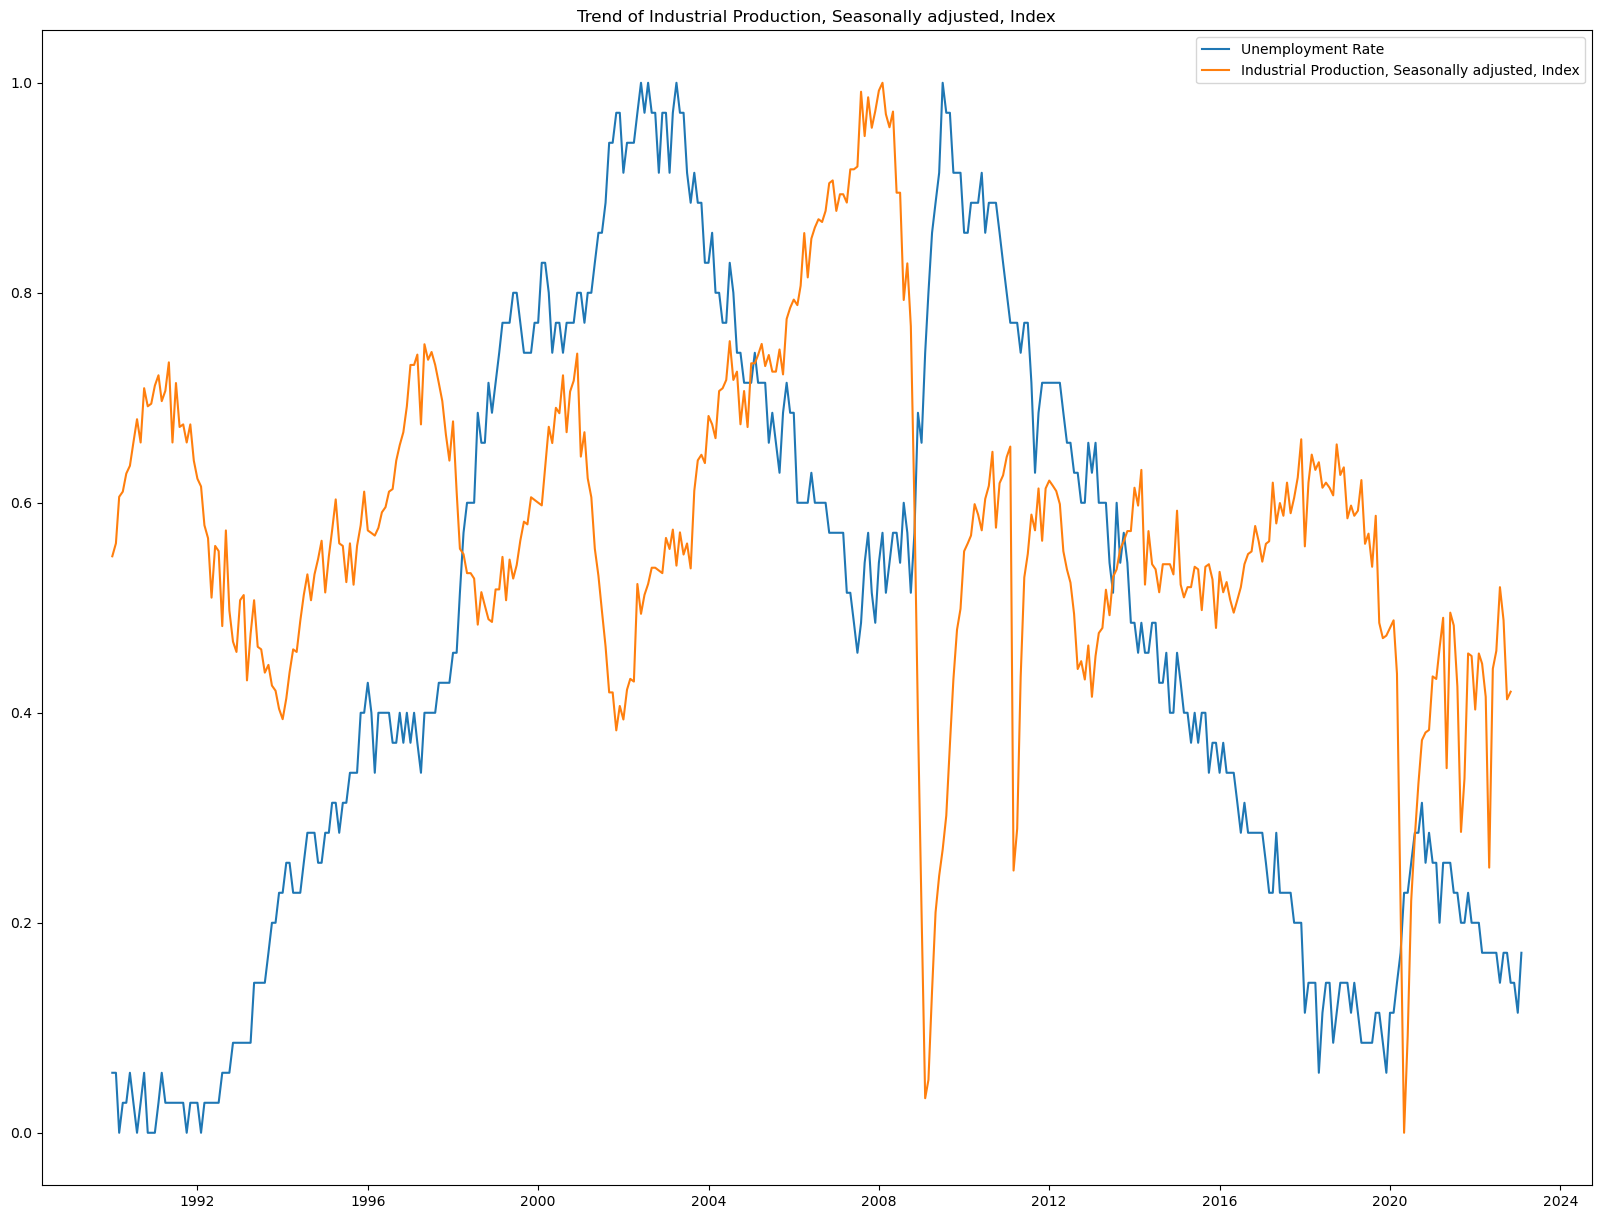

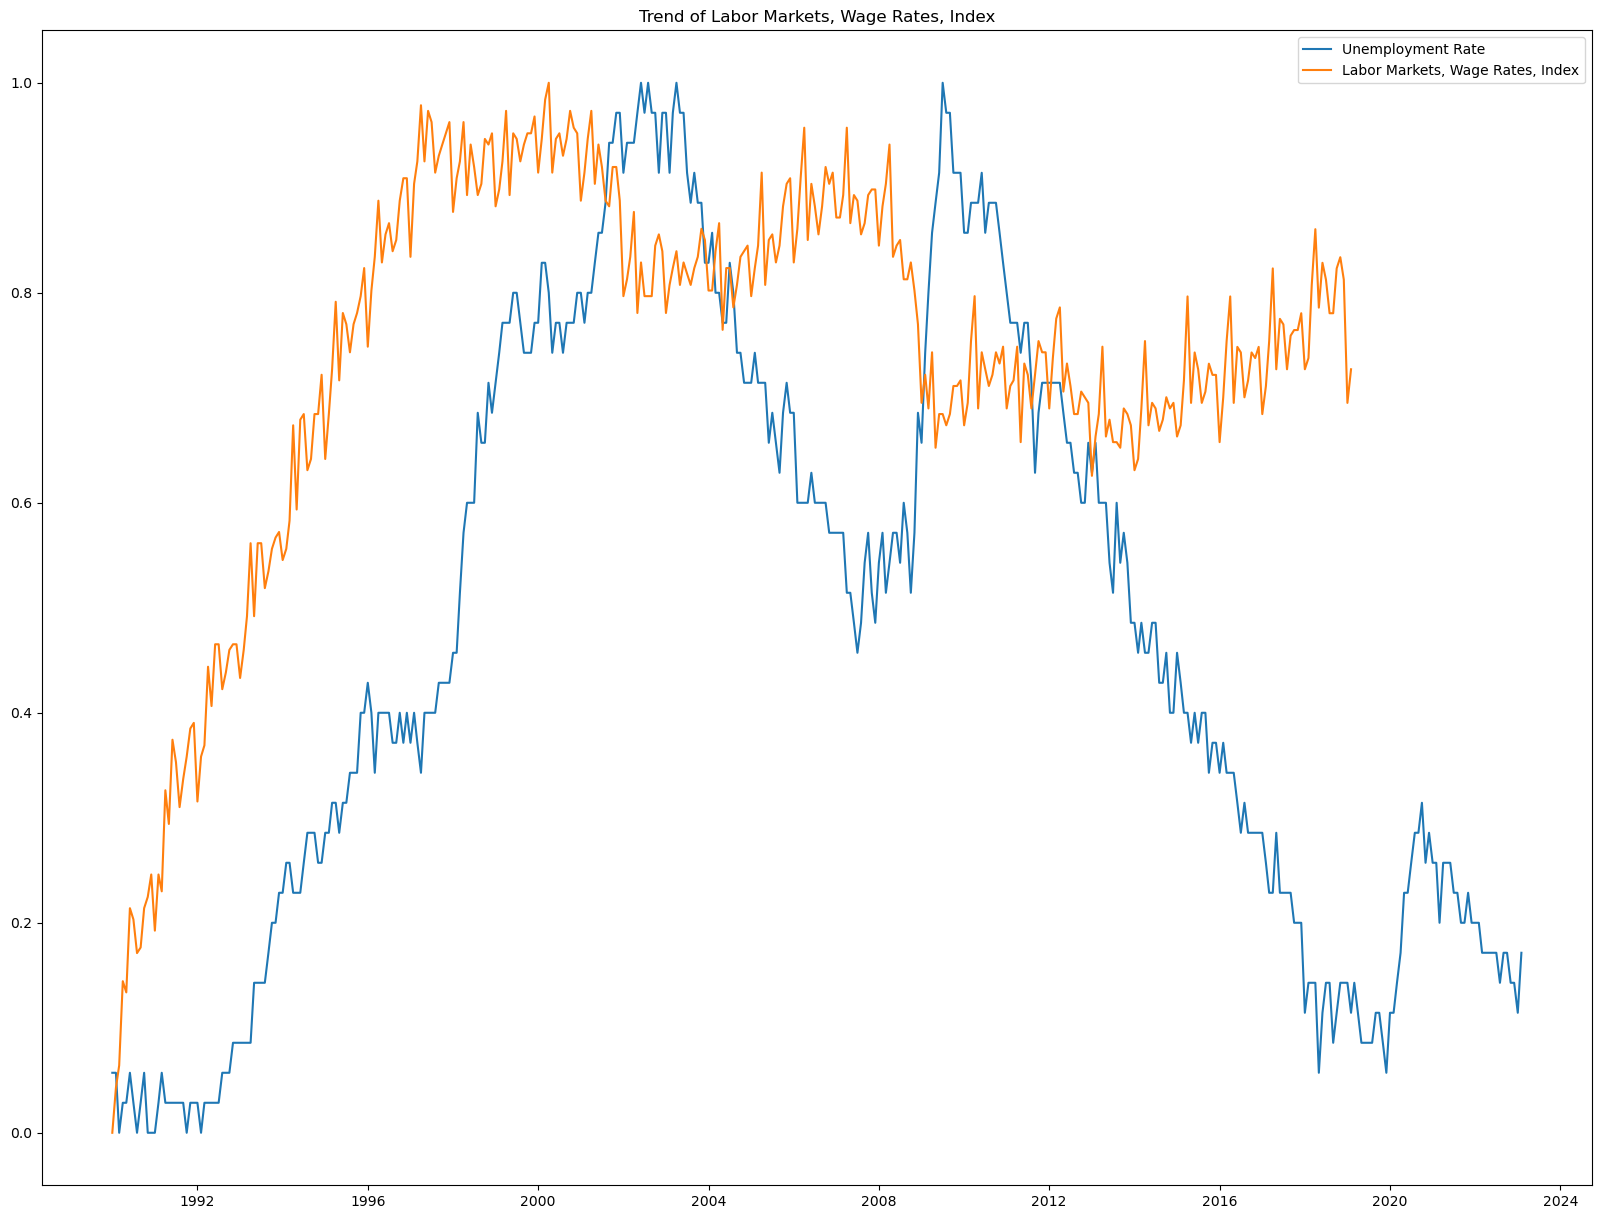

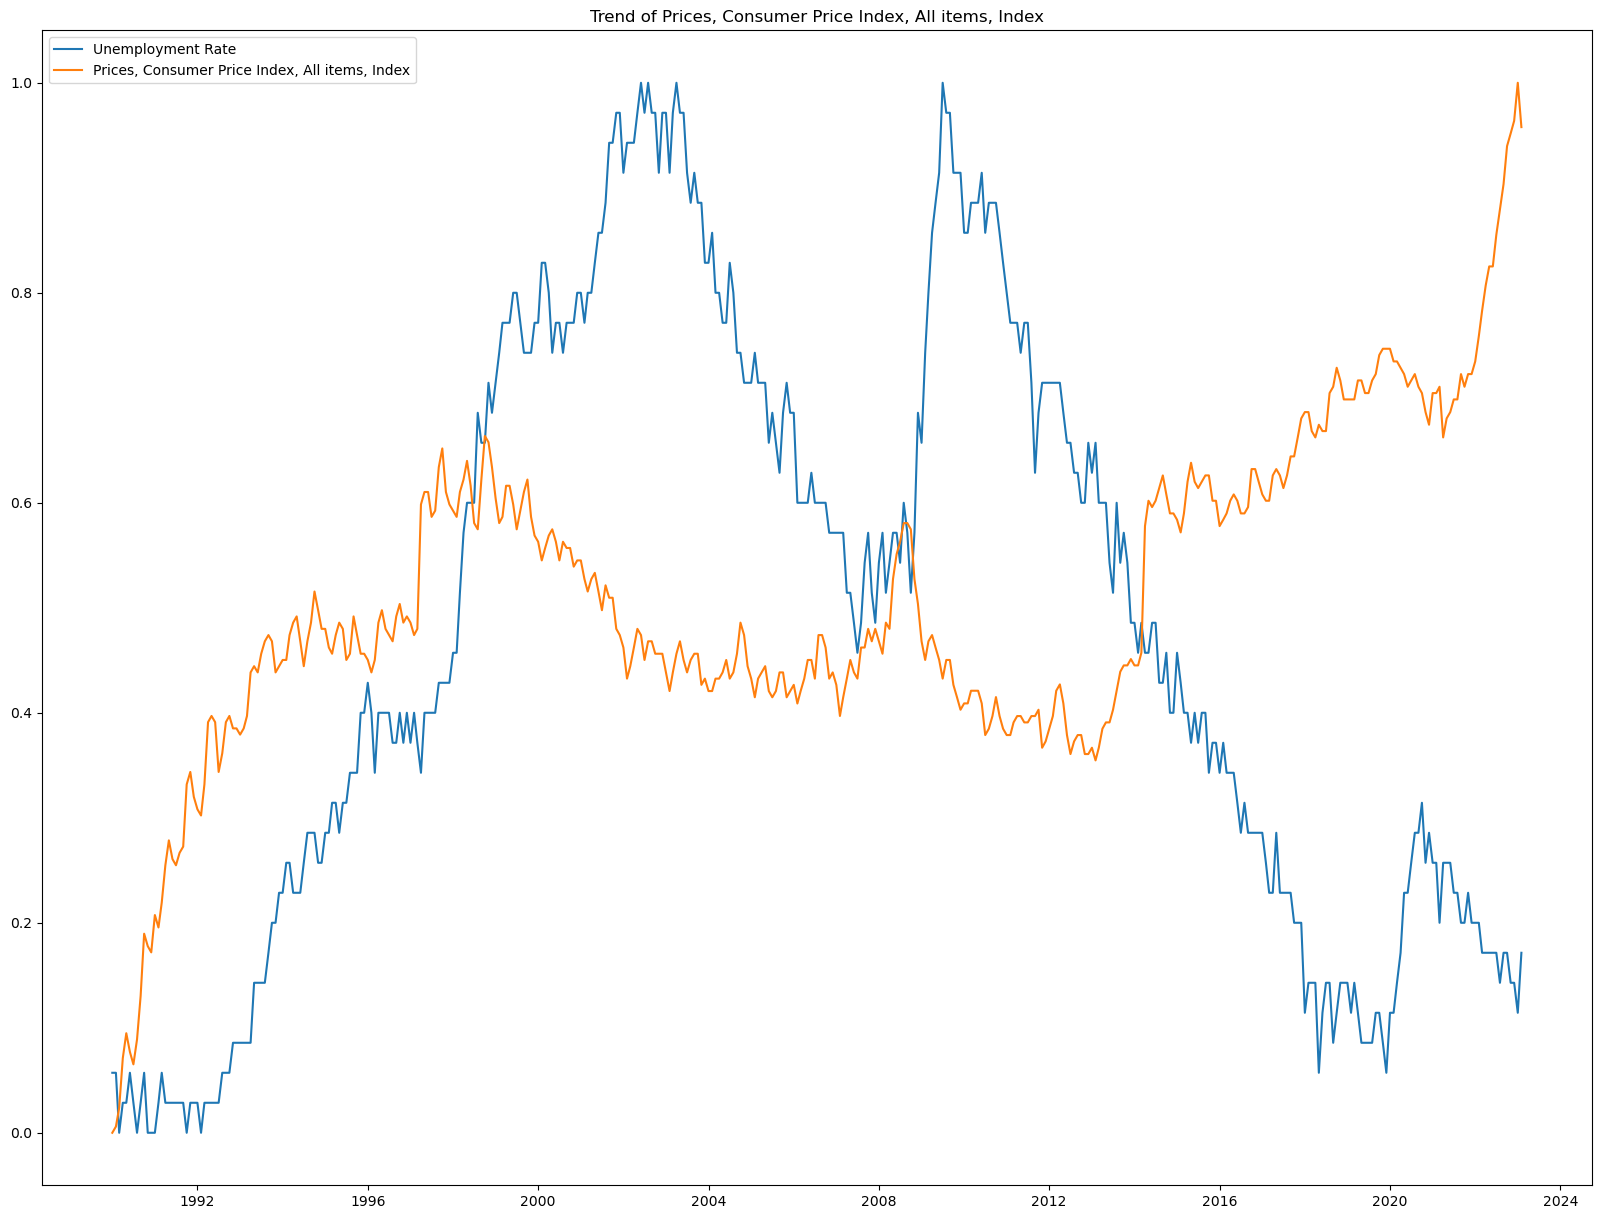

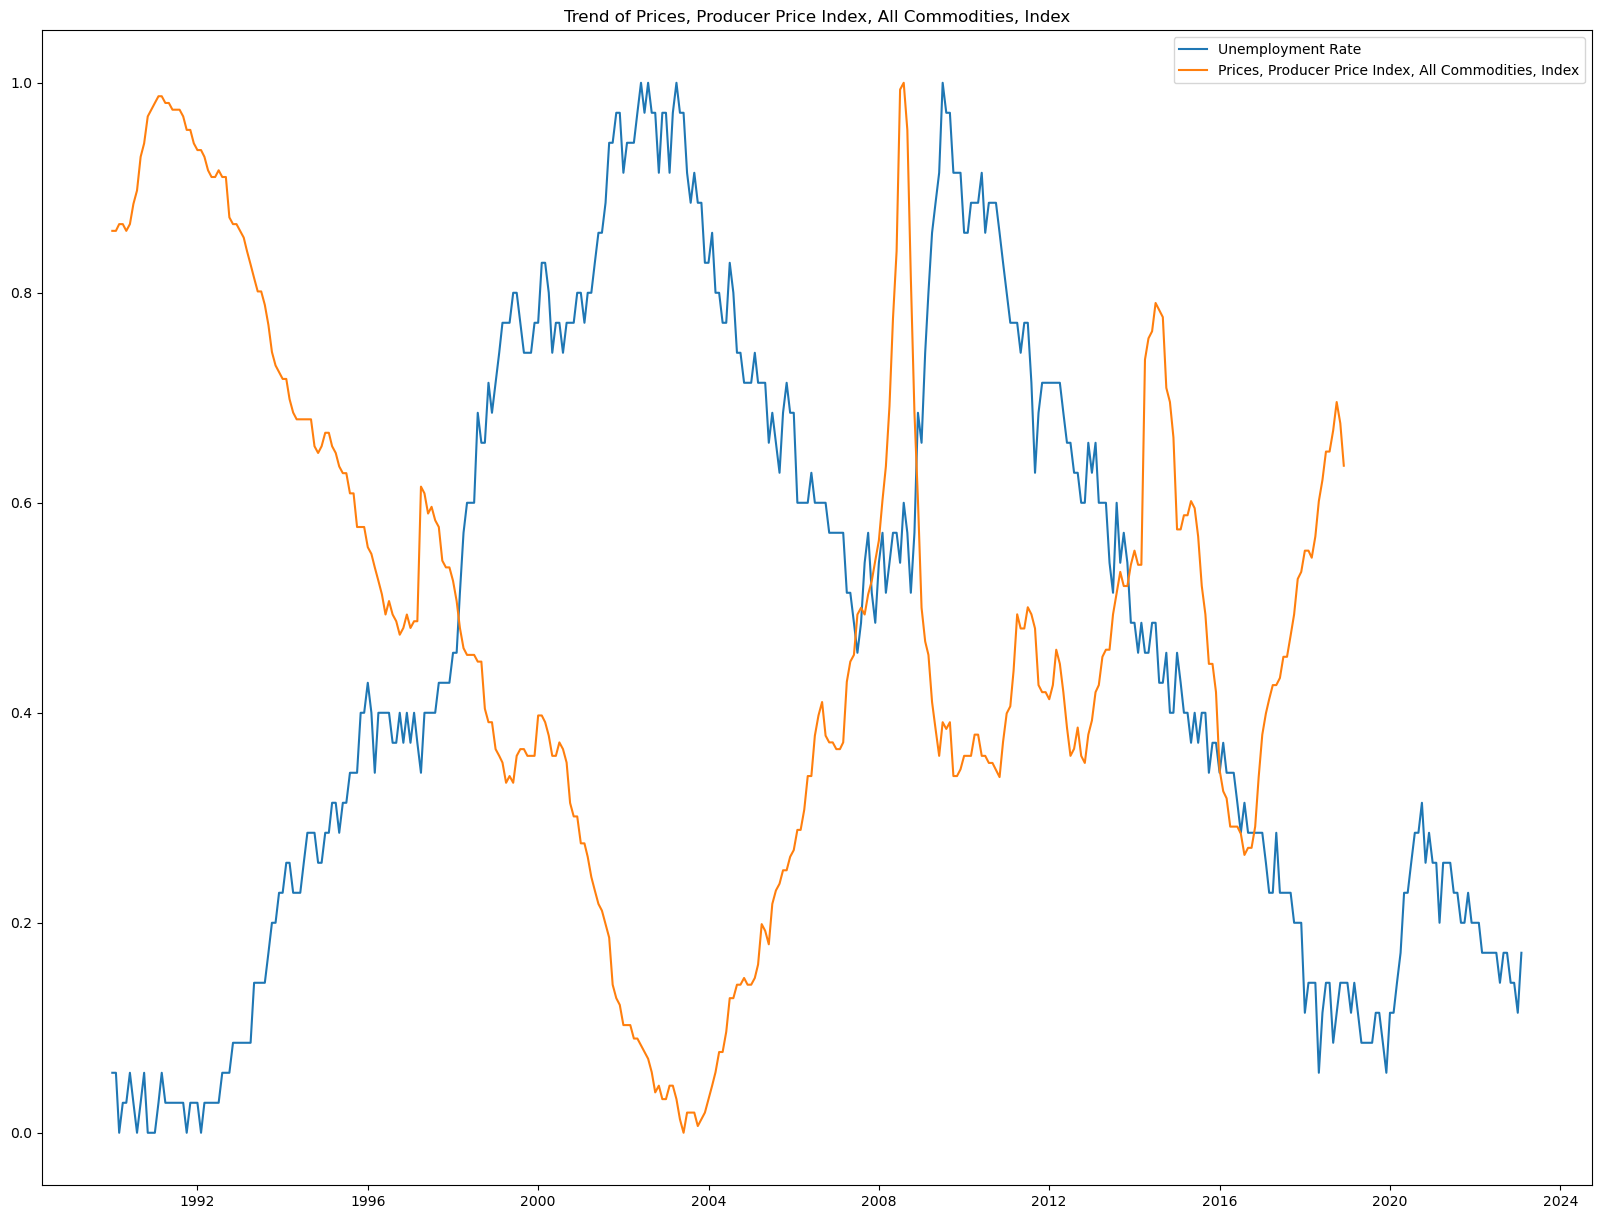

In [22]:
for col in feature_col:
    plt.plot(figsize=(15,6))
    plt.plot(df_MRD_scaled['Value'],label='Unemployment Rate')
    plt.plot(df_MRD_scaled[col],label=col)
    plt.title('Trend of %s'%(col))
    plt.legend()
    plt.show()

## 2.2. Modelling